In [1]:
!pip install eli5


  Using cached eli5-0.13.0.tar.gz (216 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107768 sha256=666ade8af3461f4bfc02fc6d94b053cca6aa2ed488324582265bb6e382cb6871
  Stored in directory: c:\users\rajas\appdata\local\pip\cache\wheels\79\6c\4b\13ea3238d017bc19711b4312359e2c95be91a1a9d60d949572
Successfully built eli5


In [5]:
!pip install matplotlib

In [6]:
!pip install pdpbox

  Using cached sklearn-0.0.post4.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [8 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\rajas\AppData\Local\Temp\pip-install-8qbr_b37\sklearn_56a9913e8b10424982fde514a2d9e5dc\setup.py", line 10, in <module>
      LONG_DESCRIPTION = f.read()
    File "C:\Users\rajas\anaconda3\lib\encodings\cp1252.py", line 23, in decode
      return codecs.charmap_decode(input,self.errors,decoding_table)[0]
  UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 7: character maps to <undefined>
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above

In [7]:
!pip install shap

     ------------------------------------- 435.6/435.6 kB 13.7 MB/s eta 0:00:00


In [9]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 8.5 MB/s eta 0:00:00


In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data = pd.read_csv('heart_cleveland_upload.csv')

In [3]:
# To display the top 5 rows
data.head(5)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0

In [4]:
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    2.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    2.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    3.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    0.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    1.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    3.000000   

             thal   condition  
count  297.000000  297.000000  
mean     0.835017    0.461279  
std      0.956690    0.499340  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      2.000000    1.000000  
max      2.000000    1.000000

In [5]:
data.shape

(297, 14)

In [6]:
heart = data.copy()

In [7]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [8]:
y = heart.pop('condition')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [10]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: total: 219 ms
Wall time: 154 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=33, ...)

In [11]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

### Permutation Importance

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

In [13]:
eli5.show_weights(xgb.get_booster(), top=15)

In [14]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In [15]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

CPU times: total: 141 ms
Wall time: 78 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=33, ...)

In [16]:
model = DecisionTreeClassifier(random_state=1)
model = model.fit(X_train, y_train)

In [17]:
permutation = PermutationImportance(model, random_state=33).fit(X_train, y_train)

In [18]:
eli5.show_weights(permutation, feature_names = features_list, top=30)

### PDP

In [19]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

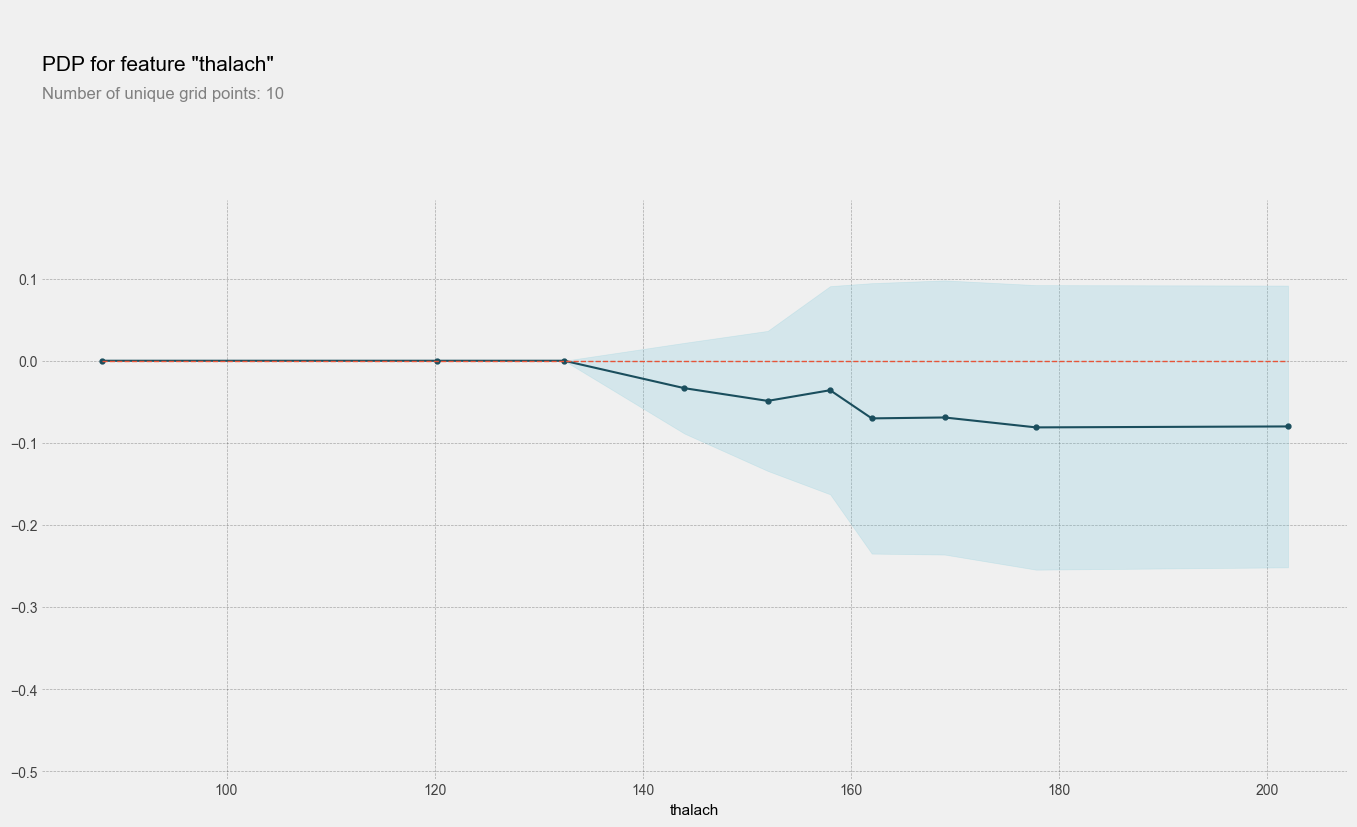

In [20]:
plot_pdp(xgb, X_train, 'thalach')

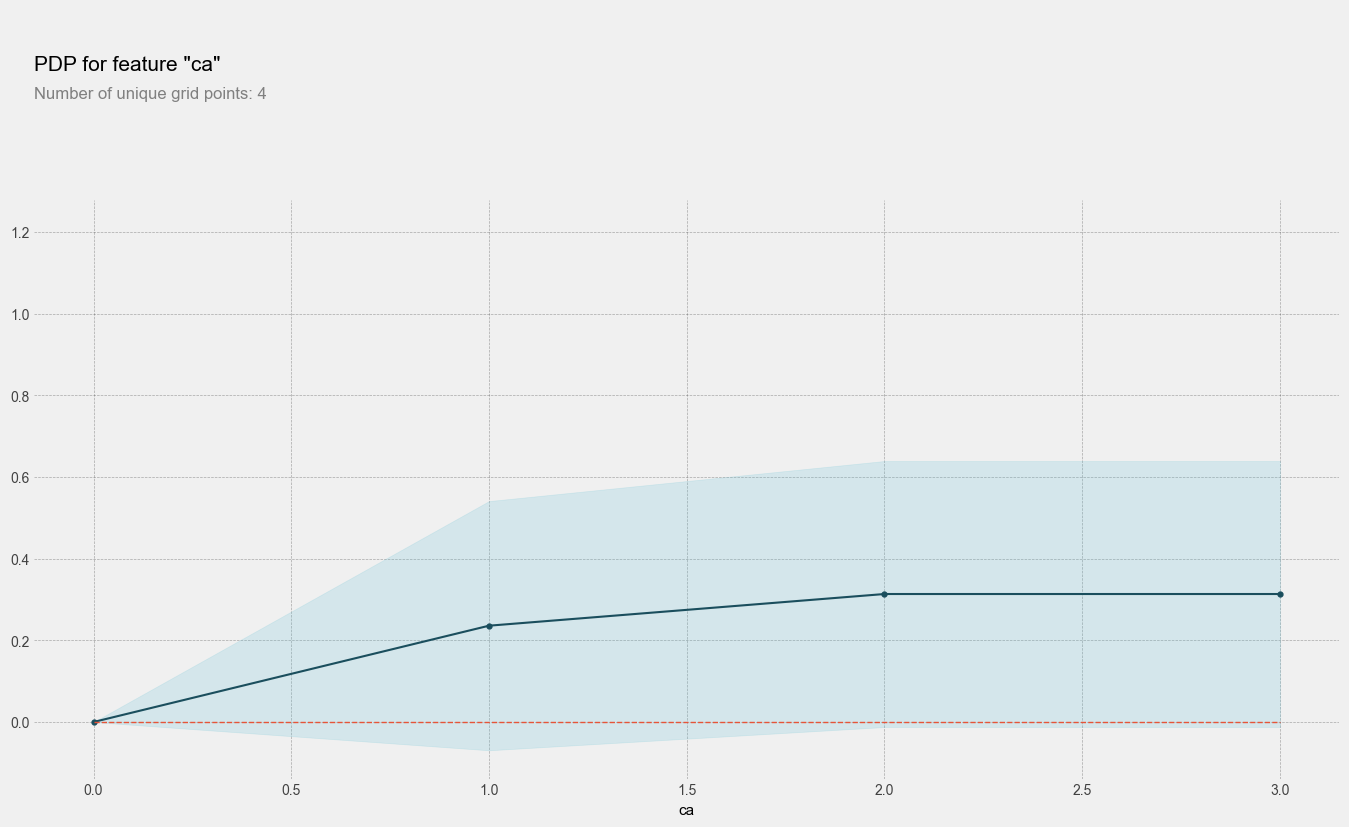

In [21]:
plot_pdp(xgb, X_train, 'ca')

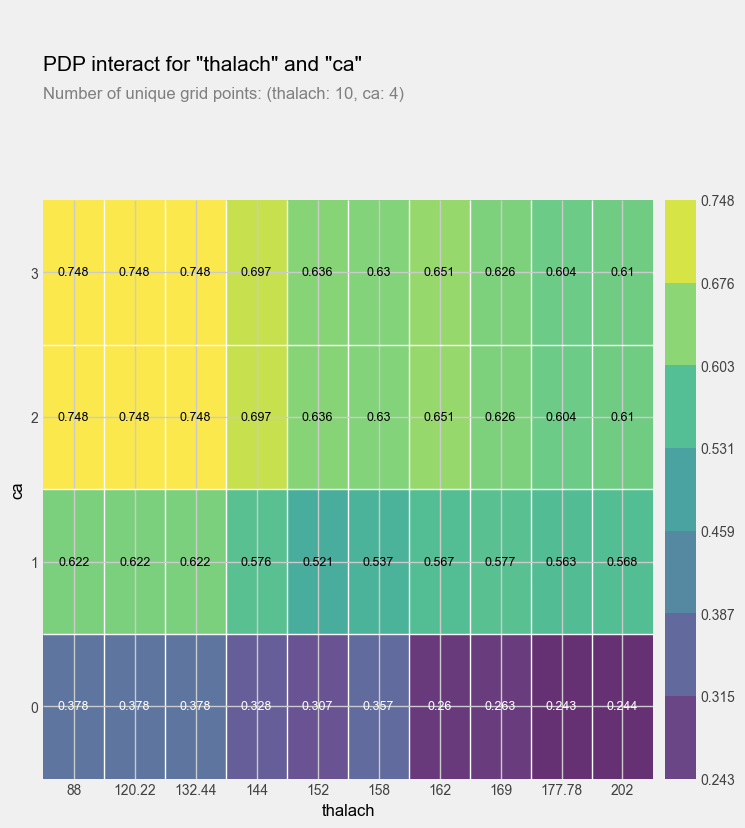

In [22]:
features_to_plot = ['thalach', 'ca']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

TypeError: KMeans.__init__() got an unexpected keyword argument 'n_jobs'

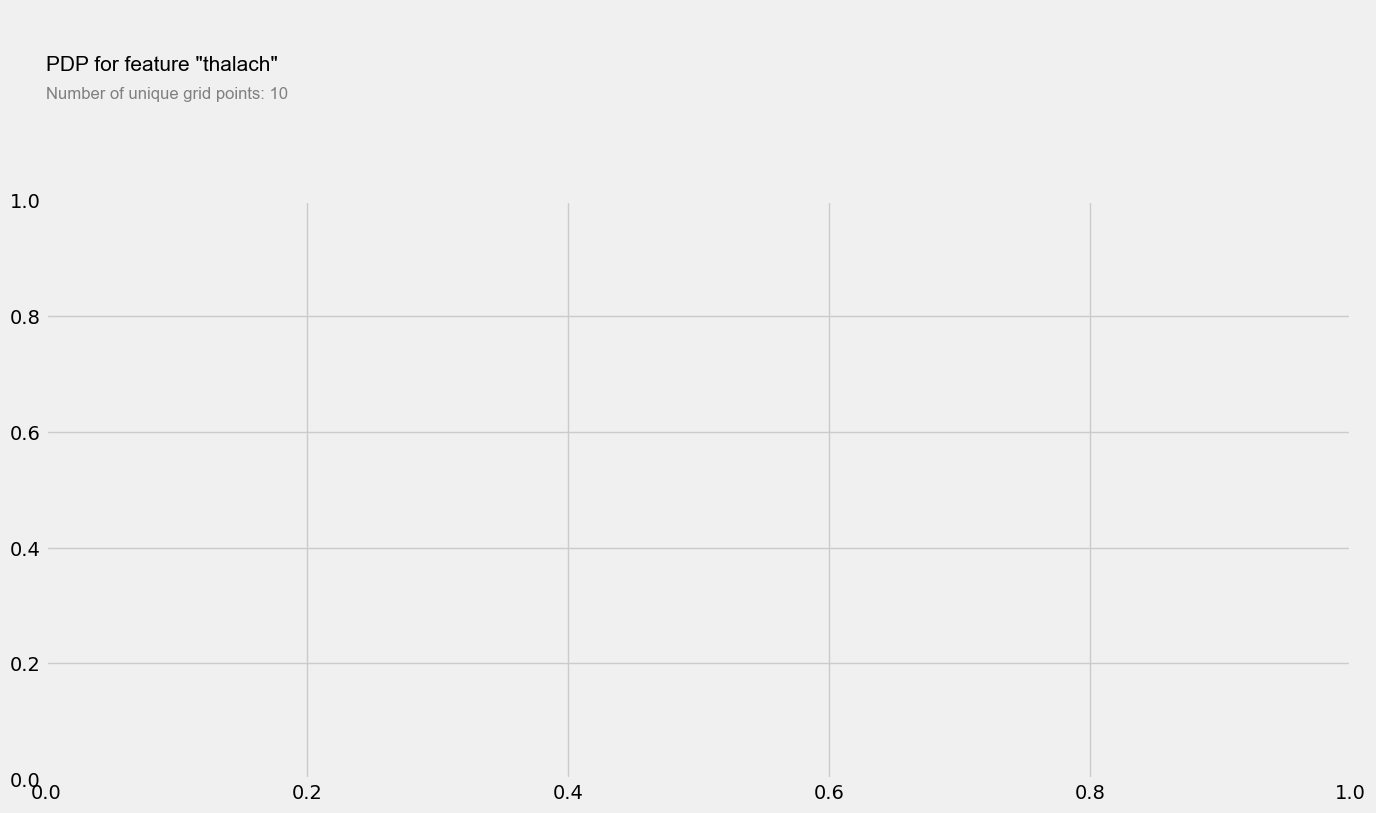

In [23]:
plot_pdp(xgb, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True)

In [24]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [25]:
interpreter = Interpretation(training_data=X_test, feature_names=features_list)
im_model = InMemoryModel(xgb.predict_proba, examples=X_train, target_names=['Disease', 'No Disease'])

In [26]:
predictions = xgb_array.predict_proba(X_test.values)

### LIME

In [27]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['No disease', 'Disease'])

In [28]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0
Predicted: [0.9983744  0.00162558]


In [29]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [1.4603138e-04 9.9985397e-01]


In [30]:
tgt = 15
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.03760159 0.9623984 ]


### SHAP

In [31]:
# pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [32]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [33]:
X_shap = pd.DataFrame(shap_values)
X_shap.head()

0         1         2         3         4         5         6   \
0  0.669860  0.482459  0.620434 -1.126800 -0.374257  0.062994 -0.680173   
1 -1.294715 -0.493515 -0.662293 -0.133700 -0.450159  0.029637 -0.192750   
2  0.028315 -0.710275  1.088892  0.558033  0.346271 -0.139676  0.310020   
3 -0.049543  0.313959  0.943176  0.082306  0.380460  0.065999 -0.398400   
4  0.018207 -0.749259  1.222633  0.544088  0.082887  0.032069  0.396871   

         7         8         9         10        11        12  
0 -0.937682 -0.053942 -2.054053 -0.233142  0.804340  0.359287  
1 -0.637688 -0.210133 -0.352575  0.916539 -1.310680 -1.164720  
2  0.610800  0.753798  1.154980  0.420168  2.170985  1.290934  
3  0.580469  0.752070  1.561530  0.518611  1.678789  1.228367  
4 -0.113106 -0.263104  1.119788  0.311731  2.392574  0.986050

In [34]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.4635163


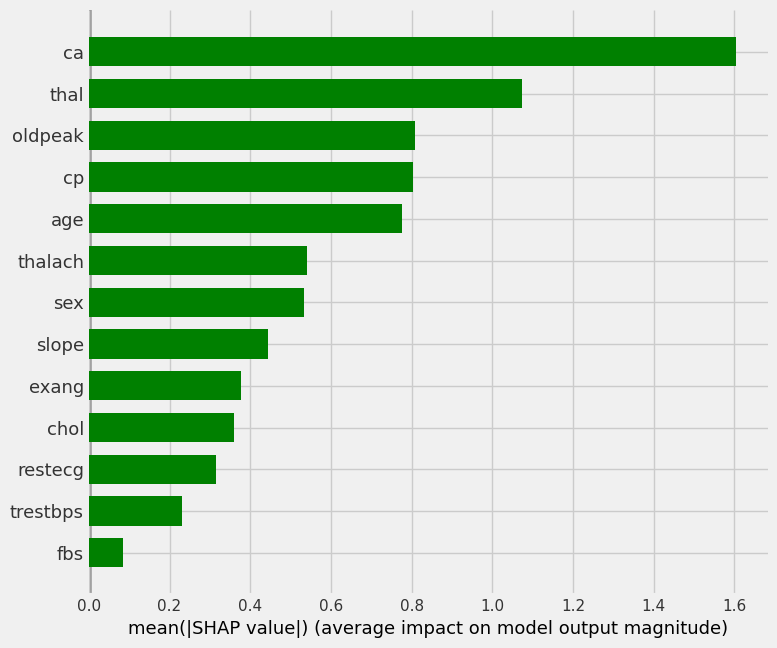

In [35]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='green')

In [36]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6,:], X_test.iloc[6,:])

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

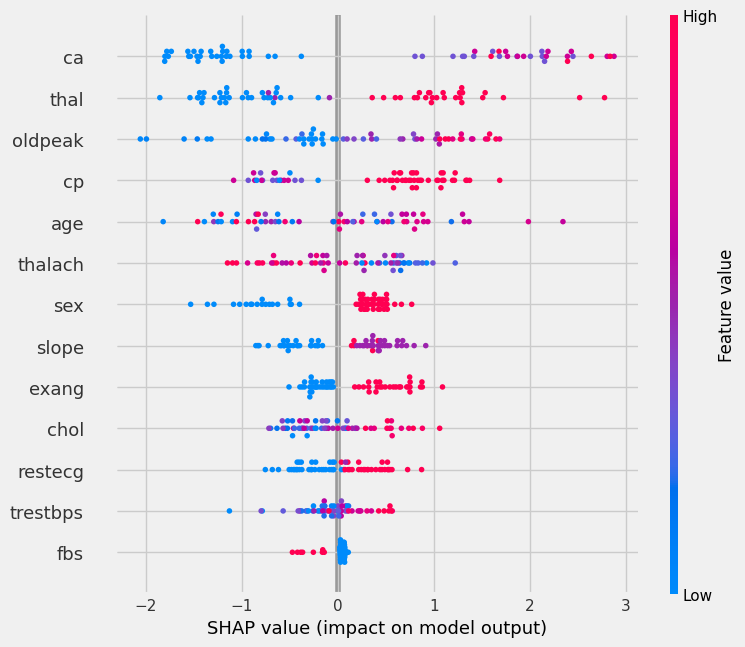

In [40]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

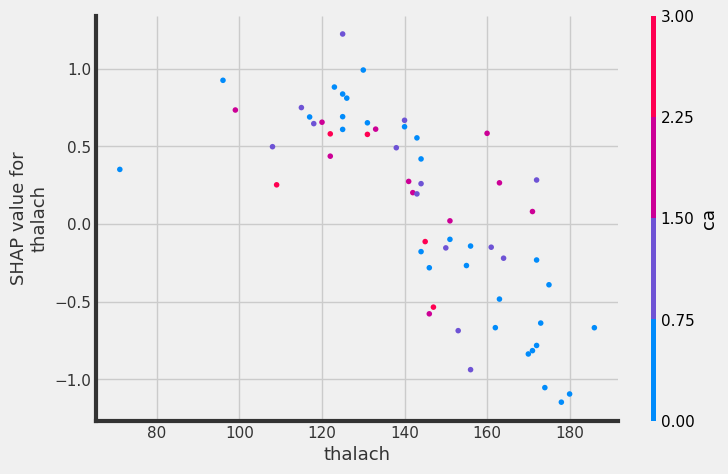

In [41]:
shap.initjs()
shap.dependence_plot(ind='thalach', interaction_index='ca',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)